# Now the real task of clustering begins! :D

## Step 4: Importing the libraries

    (a.) pandas - for data analysis

    (b.) nltk - for data preprocessing

    (c.) re - for data cleaning

In [1]:
import pandas
import nltk
import re

## Step 5 : Reading the data extracted from the Reddit API

In [2]:
# Read the data
data = [line.strip() for line in open('reddit_ques.txt', 'r')]

In [3]:
data[:10]

['What are life’s toughest mini games?',
 'What are some slang terms a 50 year old dad can say to his daughter to embarrass her?',
 'Redditors who were in attendance at a wedding that was called off mid-ceremony, what was the story?',
 'What are your best “first date tips” for somebody starting the dating game late in life (late 20’s +)?',
 'Chefs of Reddit, what are the biggest ripoffs that your restaurants sell?',
 'The year is 2050. How do you think you would complete the sentence: "Back in my day, we didn\'t have ..."?',
 'What screams "I\'m emotionally unstable"?',
 'What is an imminent danger that nobody seems to be talking about?',
 'What is the worst purchase you ever made?',
 "What's the WORST name for a strip club you can imagine?"]

In [4]:
questions = data.copy()

## Step 6: Data cleaning and Preprocessing 

In this we will perform the following operations:

    (1.) Removing the stop words.
    
    (2.) Removing the punctuations.
    
    (3.) Normalizing the words using WordNetLemmatizer in nltk
    
    (4.) Removing numbers from the words

In [30]:
# Cleaning and preprocessing

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string

stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

In [6]:
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    pun_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = ' '.join(lemma.lemmatize(word) for word in pun_free.split())
    removed_numbers = re.sub(r'\d+','',normalized)
    
    return removed_numbers.split()

## Step 7: Converting into word vectors

We will be using TF-IDF word vectors to obtain a bag of words model for our data.

Here, I define term frequency-inverse document frequency (tf-idf) vectorizer parameters and then convert the synopses list into a tf-idf matrix.

To get a Tf-idf matrix, first count word occurrences by document. This is transformed into a document-term matrix (dtm). This is also just called a term frequency matrix. An example of a dtm is here. ![](tf-idf.png)

Then apply the term frequency-inverse document frequency weighting: words that occur frequently within a document but not frequently within the corpus receive a higher weighting as these words are assumed to contain more meaning in relation to the document.

A couple things to note about the parameters I define below:

max_df: this is the maximum frequency within the documents a given feature can have to be used in the tfi-idf matrix. If the term is in greater than 80% of the documents it probably cares little meanining (in the context of film synopses)
min_idf: this could be an integer (e.g. 5) and the term would have to be in at least 5 of the documents to be considered. Here I pass 0.2; the term must be in at least 20% of the document. I found that if I allowed a lower min_df I ended up basing clustering on names--for example "Michael" or "Tom" are names found in several of the movies and the synopses use these names frequently, but the names carry no real meaning.
ngram_range: this just means I'll look at unigrams, bigrams and trigrams. See [n-grams](http://en.wikipedia.org/wiki/N-gram)

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,analyzer='word',
                                 min_df=0.001, stop_words='english',
                                 use_idf=True, ngram_range=(1,3), tokenizer=clean)

tfidf_matrix = tfidf_vectorizer.fit_transform(questions)

print(tfidf_matrix.shape)

(457, 4432)


C:\Users\MAYANK\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [9]:
terms = tfidf_vectorizer.get_feature_names()

## Step 8: Applying KMeans Clustering Algorithm

Now onto the fun part. Using the tf-idf matrix, you can run a slew of clustering algorithms to better understand the hidden structure within the synopses. I first chose k-means. K-means initializes with a pre-determined number of clusters (I chose 7). Each observation is assigned to a cluster (cluster assignment) so as to minimize the within cluster sum of squares. Next, the mean of the clustered observations is calculated and used as the new cluster centroid. Then, observations are reassigned to clusters and centroids recalculated in an iterative process until the algorithm reaches convergence.

I found it took several runs for the algorithm to converge a global optimum as k-means is susceptible to reaching local optima.

In [33]:
# Defining the similarity metric

from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [32]:
from sklearn.cluster import KMeans

num_clusters = 7

km = KMeans(n_clusters=num_clusters)

km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

In [34]:
# Creating a pandas dataframe to store the results 

import pandas as pd

questions_f = {'ques': data, 'cluster': clusters}
frame = pd.DataFrame(questions_f, index=[clusters], columns=['ques', 'cluster'])

In [35]:
# Observing the distribution of clusters.

print('Clusters and their counts: ')
frame['cluster'].value_counts()

Clusters and their counts: 


0    231
4     57
3     42
6     36
1     35
2     32
5     24
Name: cluster, dtype: int64

## Step 9 : Visualizing the results

#### Visualizing how questions are around the clusters and what are the important cluster words

In [21]:
print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :6]:
        print(' %s' % terms[ind],end=',')
    print()
    print()
    print("Cluster %d questions:" % i, end='')
    for title in frame.ix[i]['ques'].values.tolist():
        print(' %s,' % title, end='')
    print()
    print()

Top terms per cluster:

Cluster 0 words: thing, what’s, best, like, redditors, think,

Cluster 0 questions: What are life’s toughest mini games?, What are some slang terms a 50 year old dad can say to his daughter to embarrass her?, Redditors who were in attendance at a wedding that was called off mid-ceremony, what was the story?, The year is 2050. How do you think you would complete the sentence: "Back in my day, we didn't have ..."?, What screams "I'm emotionally unstable"?, What is an imminent danger that nobody seems to be talking about?, What’s something that you only do because it’s socially standard?, What mildly illegal thing do you do?, What do you regret doing at university?, What song fills you with the most emotions (positive or negative) and why?, What game have you spent the most hours playing?, Which artist has the fakest public image?, What is a common internet thing that you hate?, What is something that was normal in your childhood, but now you realize was weird/not 

C:\Users\MAYANK\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  # This is added back by InteractiveShellApp.init_path()


#### Multidimensional Scaling

In [22]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [23]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

In [25]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e', 5: '#ffff00', 6:'#00008b'}

#set up cluster names using a dict
cluster_names = {0: 'like, best, think', 
                 1: 'life, changes, difficult', 
                 2: 'superlatives, movie', 
                 3: 'worst moments', 
                 4: 'people on reddit',
                 5: 'knowledge , work',
                 6: 'ask reddit ques'}

In [26]:
%matplotlib inline

### Visualizing the final results

C:\Users\MAYANK\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


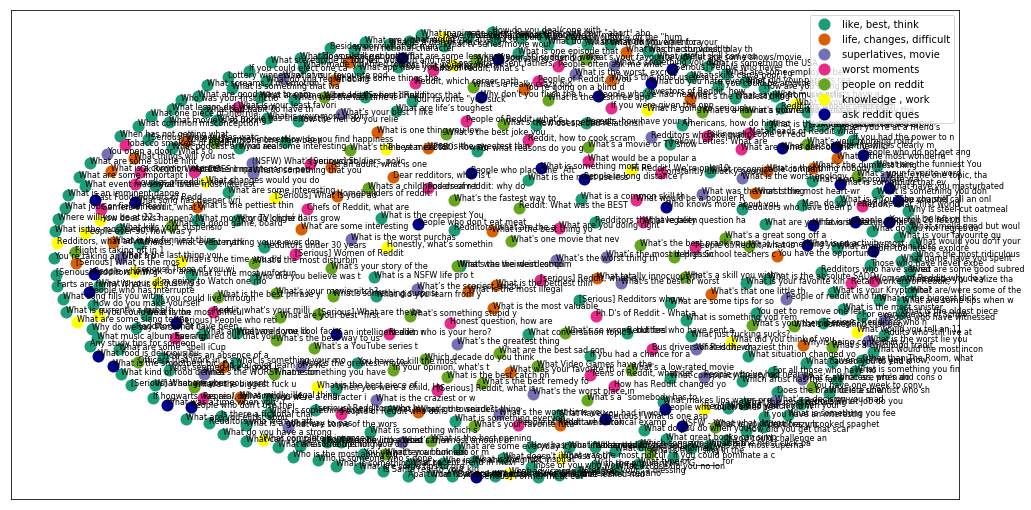

In [36]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=data)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'][:25], size=8)  

    
    
plt.show() #show the plot

plt.savefig('clusters_small_noaxes.png', dpi=200)